In [61]:
# 加载数据
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import os, time; 
print('PID=', os.getpid(), 'T=', time.time())


# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_set = load('../dataresult/train_set')
    train_label = load('../dataresult/train_label')
    # 测试集
    test_set = load('../dataresult/test_set')
    test_label = load('../dataresult/test_label')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_set, train_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_set, test_label),
                                  batch_size=batch_size, num_workers=workers, drop_last=True)
    return train_loader, test_loader

batch_size = 32
# 加载数据
train_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(test_loader))

PID= 25468 T= 1747968452.4367347
114
70


In [62]:
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer
class TransformerBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes,hidden_dim, num_layers, num_heads, output_dim, dropout_rate=0.5):
        """
        params:
        input_dim          : 输入数据的维度
        hidden_layer_sizes : bilstm 隐藏层的数目和维度
        hidden_dim          : 注意力维度
        num_layers          : Transformer编码器层数
        num_heads           : 多头注意力头数
        output_dim         : 输出维度
        dropout_rate        : 随机丢弃神经元的概率
        """
        super().__init__()
          # 上采样操作
        self.unsampling = nn.Conv1d(input_dim, 32, 1)

        # Transformer编码器  Transformer layers
        self.hidden_dim = hidden_dim
        self.transformer = TransformerEncoder(
            TransformerEncoderLayer(32, num_heads, hidden_dim, dropout=dropout_rate, batch_first=True),
            num_layers
        )

        # BiLSTM参数
        self.num_layers = len(hidden_layer_sizes)  # bilstm层数
        self.bilstm_layers = nn.ModuleList()  # 用于保存BiLSTM层的列表
        # 定义第一层BiLSTM   
        self.bilstm_layers.append(nn.LSTM(32, hidden_layer_sizes[0], batch_first=True, bidirectional=True))
        # 定义后续的BiLSTM层
        for i in range(1, self.num_layers):
                self.bilstm_layers.append(nn.LSTM(hidden_layer_sizes[i-1]* 2, hidden_layer_sizes[i], batch_first=True, bidirectional=True))

        # 定义线性层
        self.linear  = nn.Linear(hidden_layer_sizes[-1] * 2, output_dim)


    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        # 预处理  先进行上采样
        unsampling = self.unsampling(input_seq.permute(0,2,1))  
        # Transformer 处理
        # 在PyTorch中，transformer模型的性能与batch_first参数的设置相关。
        # 当batch_first为True时，输入的形状应为(batch, sequence, feature)，这种设置在某些情况下可以提高推理性能。
        transformer_output = self.transformer(unsampling.permute(0,2,1))  #  torch.Size([32, 7, 8])

        # 送入 BiLSTM 层
        #改变输入形状，bilstm 适应网络输入[batch, seq_length, H_in]
        bilstm_out = transformer_output
        for bilstm in self.bilstm_layers:
            bilstm_out, _= bilstm(bilstm_out)  ## 进行一次BiLSTM层的前向传播  # torch.Size([32, 12, 128])
        predict = self.linear(bilstm_out[:, -1, :]) # torch.Size([32, 1]  # 仅使用最后一个时间步的输出 
        return predict

In [63]:
# 定义模型参数
input_dim = 14   # 输入维度为 14 个特征
hidden_layer_sizes = [32, 64]  # BiLSTM 层 结构
# Transformer参数
hidden_dim = 128  # 注意力维度
num_layers = 2   # 编码器层数
num_heads = 2   # 多头注意力头数
output_dim = 1 # 输出维度为 1

model = TransformerBiLSTM(input_dim, hidden_layer_sizes,hidden_dim, num_layers, num_heads, output_dim)  

# 定义损失函数和优化函数 
loss_function = nn.MSELoss()  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器



# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

   448
    32
  3072
    96
  1024
    32
  4096
   128
  4096
    32
    32
    32
    32
    32
  3072
    96
  1024
    32
  4096
   128
  4096
    32
    32
    32
    32
    32
  4096
  4096
   128
   128
  4096
  4096
   128
   128
 16384
 16384
   256
   256
 16384
 16384
   256
   256
   128
     1
______
109473


In [64]:
print(model)

TransformerBiLSTM(
  (unsampling): Conv1d(14, 32, kernel_size=(1,), stride=(1,))
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=128, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=128, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (bilstm_layers): ModuleList(
    (0): LSTM(32, 32, batch_first=True, bidirectional=True)
    (1): LSTM(64, 64, batch_first=True, bidirectional=True)
  )
  (linear): Linear(in_features=128, out_features=1, bias=True

Epoch:  1 train_MSE-Loss: 0.52368200
Epoch:  2 train_MSE-Loss: 0.16226783
Epoch:  3 train_MSE-Loss: 0.12206619
Epoch:  4 train_MSE-Loss: 0.12925291
Epoch:  5 train_MSE-Loss: 0.16249570
Epoch:  6 train_MSE-Loss: 0.12017130
Epoch:  7 train_MSE-Loss: 0.09149825
Epoch:  8 train_MSE-Loss: 0.07574016
Epoch:  9 train_MSE-Loss: 0.05970092
Epoch: 10 train_MSE-Loss: 0.04204067
Epoch: 11 train_MSE-Loss: 0.02770130
Epoch: 12 train_MSE-Loss: 0.02160771
Epoch: 13 train_MSE-Loss: 0.02140632
Epoch: 14 train_MSE-Loss: 0.02678534
Epoch: 15 train_MSE-Loss: 0.03287059
Epoch: 16 train_MSE-Loss: 0.02755830
Epoch: 17 train_MSE-Loss: 0.02000637
Epoch: 18 train_MSE-Loss: 0.01843788
Epoch: 19 train_MSE-Loss: 0.01639934
Epoch: 20 train_MSE-Loss: 0.02075961
Epoch: 21 train_MSE-Loss: 0.03425104
Epoch: 22 train_MSE-Loss: 0.02742482
Epoch: 23 train_MSE-Loss: 0.01550270
Epoch: 24 train_MSE-Loss: 0.01600732
Epoch: 25 train_MSE-Loss: 0.01266890
Epoch: 26 train_MSE-Loss: 0.02026774
Epoch: 27 train_MSE-Loss: 0.02868488
E

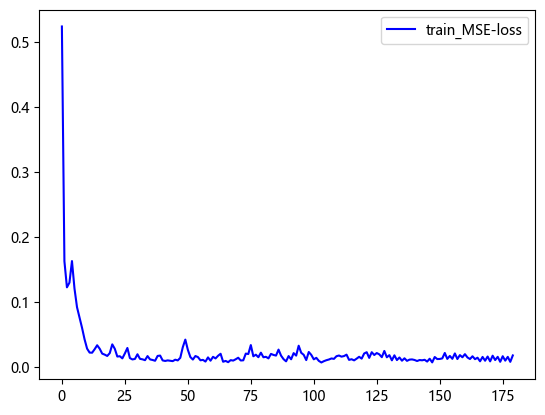

min_MSE: 0.006363635717813547


In [65]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(epochs, model, optimizer, loss_function, train_loader, device):
    model = model.to(device)

    # 最低MSE  
    minimum_mse = 1000.
    # 最佳模型
    best_model = model

    train_mse = []     # 记录在训练集上每个epoch的 MSE 指标的变化情况   平均值
  
    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
         # 训练
        model.train()
        train_mse_loss = []    #保存当前epoch的MSE loss和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 损失计算
            loss = loss_function(y_pred, labels)
            train_mse_loss.append(loss.item()) # 计算 MSE 损失
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算总损失
        train_av_mseloss = np.average(train_mse_loss) # 平均
        train_mse.append(train_av_mseloss)
        print(f'Epoch: {epoch+1:2} train_MSE-Loss: {train_av_mseloss:10.8f}')
       
        # 如果当前模型的 MSE 低于于之前的最佳准确率，则更新最佳模型
        #保存当前最优模型参数
        if train_av_mseloss < minimum_mse:
            minimum_mse = train_av_mseloss
            best_model = model# 更新最佳模型的参数
         
    # 保存最后的参数
    # torch.save(model, 'final_model_transformer_bilstm.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_transformer_bilstm.pt')
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    
    # 可视化
    plt.plot(range(epochs), train_mse, color = 'b',label = 'train_MSE-loss')
    plt.legend()
    plt.show()   #显示 lable 
    print(f'min_MSE: {minimum_mse}')

#  模型训练
# epochs = 160  0.897
epochs = 180
model_train(epochs, model, optimizer, loss_function, train_loader, device)

### 第一部分，训练集评估

In [66]:
# 模型预测
# 模型 测试集 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_transformer_bilstm.pt')
model = model.to(device)

# 预测数据
origin_data = []
pre_data = []
with torch.no_grad():
        for data, label in train_loader:
            # 原始标签
            origin_lable = label.tolist()
            origin_data += origin_lable
            model.eval()  # 将模型设置为评估模式
            
            # 预测
            data, label = data.to(device), label.to(device)
            train_pred = model(data)  # 对测试集进行预测
            train_pred = train_pred.tolist()
            pre_data += train_pred      

C:\Users\Delta\AppData\Local\Temp\ipykernel_25468\3744078429.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_transformer_bilstm.pt')


In [67]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('../dataresult/scaler')
origin_data = scaler.inverse_transform(origin_data)
pre_data = scaler.inverse_transform(pre_data)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(origin_data, pre_data)
print('训练集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
train_mse = mean_squared_error(origin_data, pre_data)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(origin_data, pre_data)
print('训练数据集上的均方误差-MSE: ',train_mse)
print('训练数据集上的均方根误差-RMSE: ',train_rmse)
print('训练数据集上的平均绝对误差-MAE: ',train_mae)

训练集上 模型分数-R^2: 0.9815866946468456
**************************************************
训练数据集上的均方误差-MSE:  0.0015129837124583049
训练数据集上的均方根误差-RMSE:  0.03889709131102614
训练数据集上的平均绝对误差-MAE:  0.03109985085396633


# 测试集评估

In [68]:
# 模型 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_transformer_bilstm.pt')
model = model.to(device)

# 预测数据
test_origin_data = []
test__pre_data = []
with torch.no_grad():
        for data, label in test_loader:
            # 原始标签
            origin_lable = label.tolist()
            test_origin_data += origin_lable
            model.eval()  # 将模型设置为评估模式
            
            # 预测
            data, label = data.to(device), label.to(device)
            pred = model(data)  # 对测试集进行预测
            pred = pred.tolist()
            test__pre_data += pred        

C:\Users\Delta\AppData\Local\Temp\ipykernel_25468\126958278.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_transformer_bilstm.pt')


In [69]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('../dataresult/scaler')
test_origin_data = scaler.inverse_transform(test_origin_data)
test__pre_data = scaler.inverse_transform(test__pre_data)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(test_origin_data, test__pre_data)
print('测试集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
test_mse = mean_squared_error(test_origin_data, test__pre_data)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_origin_data, test__pre_data)
print('测试数据集上的均方误差-MSE: ',test_mse)
print('测试数据集上的均方根误差-RMSE: ',test_rmse)
print('测试数据集上的平均绝对误差-MAE: ',test_mae)

测试集上 模型分数-R^2: 0.9566171306213531
**************************************************
测试数据集上的均方误差-MSE:  0.0035546800384916102
测试数据集上的均方根误差-RMSE:  0.059621137514237435
测试数据集上的平均绝对误差-MAE:  0.049797929572990444


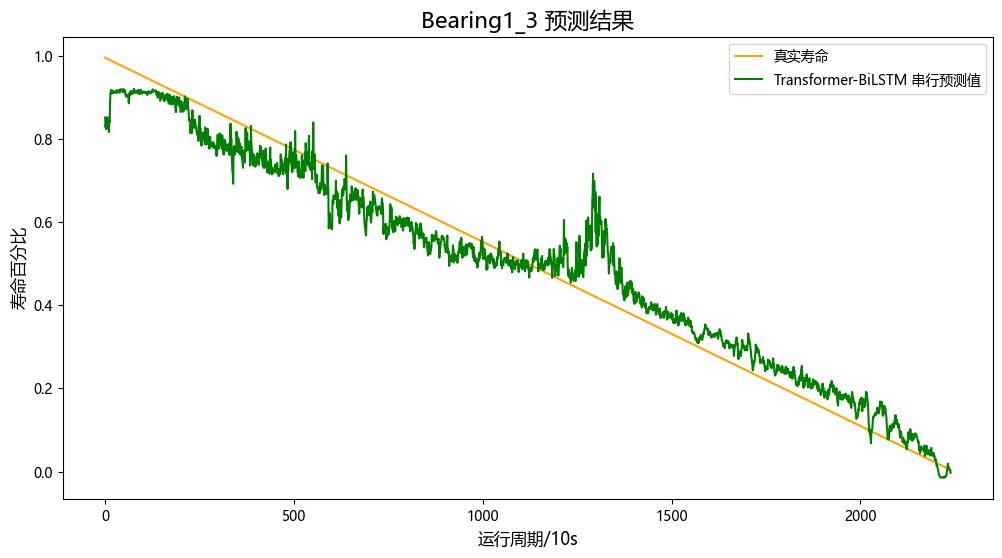

['../画图对比/transformer_bilstm_serial_pre']

In [70]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_origin_data, label='真实寿命',color='orange')  # 真实值
plt.plot(test__pre_data, label='Transformer-BiLSTM 串行预测值',color='green')  # 预测值

# plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')  # 临界点直线  可自己调整位置

plt.xlabel('运行周期/10s', fontsize=12)
plt.ylabel('寿命百分比', fontsize=12)
plt.title('Bearing1_3 预测结果', fontsize=16)
plt.legend()
plt.show()

# 保存数据best_model_transformer_bilstm
# 保存数据
dump(test_origin_data, '../画图对比/transformer_bilstm_serial_origin') 
dump(test__pre_data, '../画图对比/transformer_bilstm_serial_pre') 